# Mesure de contraste

In [1]:
# Setting working directory
import os
os.chdir('C:/Users/Emilie/Documents/Formation Datascientest/Projet Analyse Pulmonaire/')
# os.chdir('C:/Users/peure/Documents/Formation Datascientest/Projet Analyse Pulmonaire/')

In [284]:
import pandas as pd
import numpy as np
import cv2
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [42]:
# Chargement des métadonnées

dir_viral_pneum = "Data/Viral Pneumonia/images"
dir_bact_pneum = "Data/Lung_Opacity/images"
dir_covid = "Data/COVID/images"
dir_normal = "Data/Normal/images"

list_dir_images = pd.DataFrame({"img_type" : ["Viral Pneumonia", "Bacterial Pneumonia", "Covid", "Normal"],
                                "img_dir" : [dir_viral_pneum, dir_bact_pneum, dir_covid, dir_normal]})

,img_type,img_dir
0,Viral Pneumonia,Data/Viral Pneumonia/images
1,Bacterial Pneumonia,Data/Lung_Opacity/images
2,Covid,Data/COVID/images
3,Normal,Data/Normal/images


In [43]:
data_meta = pd.read_csv("Data/aggregated_metadata.csv", index_col=0)
data_meta.head()

,file_name,format,resolution,url,data_type
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,Covid
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,Covid
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,Covid
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,Covid
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,Covid


## Indicateurs de contraste et de lisibilité des images

In [24]:

def contrast(img, alpha):
    """
   Arg : 
   img : np.array en 1 dim
   alpha : niveau de proba 
   Returns :
   Indicateur (scalaire) : écart interquantile (d'ampliture 1-2*alpha) renormalisé par l'amplitude
    """
    i1 = (np.diff(np.quantile(img, q=(0+alpha,1-alpha))))/(np.max(img) - np.min(img))
    return i1[0]

In [331]:
# Calcul de l'indice de contraste, du niveau moyen et de l'écart-type des niveaux de gris de chaque image.

q_seuil = 0.05
contrast_df = []

for k, dir in enumerate(list_dir_images.img_dir):
    dir_images = dir
    filenames = [name for name in os.listdir(dir_images)]
    files_size = len(filenames)
    for i, filename in enumerate(filenames):
        curr_img = cv2.imread(os.path.join(dir_images, filename))
        contrast_df.append([filename.split('.')[0],  contrast(curr_img, alpha=q_seuil), np.mean(curr_img), np.std(curr_img)])


contrast_df = pd.DataFrame(contrast_df, columns=["file_name", "contrast", "color_mean", "color_std"])


In [332]:
# Fusion des métadonnées avec les indicateurs de contraste calculés

data_meta['name_lower'] = data_meta['file_name'].str.lower()
contrast_df['name_lower'] = contrast_df['file_name'].str.lower()
contrast_img_data = data_meta.drop(columns=['resolution', 'format']).merge(contrast_df, on="name_lower")

contrast_img_data = contrast_img_data.drop(columns=['file_name_y', 'name_lower']).rename({'file_name_x' : 'file_name'})


In [333]:
print(contrast_df.shape)
print(data_meta.shape)
contrast_img_data.info()
contrast_img_data.describe()


(21165, 5)
(21165, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 21165 entries, 0 to 21164
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name_x  21165 non-null  object 
 1   url          21165 non-null  object 
 2   data_type    21165 non-null  object 
 3   contrast     21165 non-null  float64
 4   color_mean   21165 non-null  float64
 5   color_std    21165 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.1+ MB


,contrast,color_mean,color_std
count,21165.000000,21165.000000,21165.000000
mean,0.784941,129.908506,59.017312
std,0.117770,23.491756,11.104801
min,0.159836,25.511381,14.145251
25%,0.721569,113.313184,51.657089
50%,0.811765,127.133891,60.104209
75%,0.869565,146.682901,67.152950
max,1.000000,229.141676,106.998675


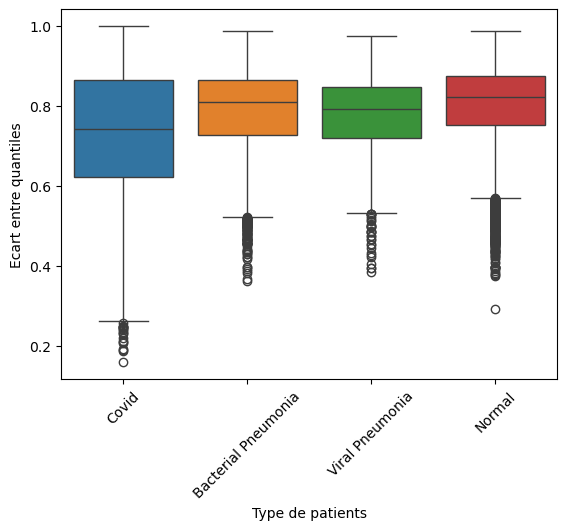

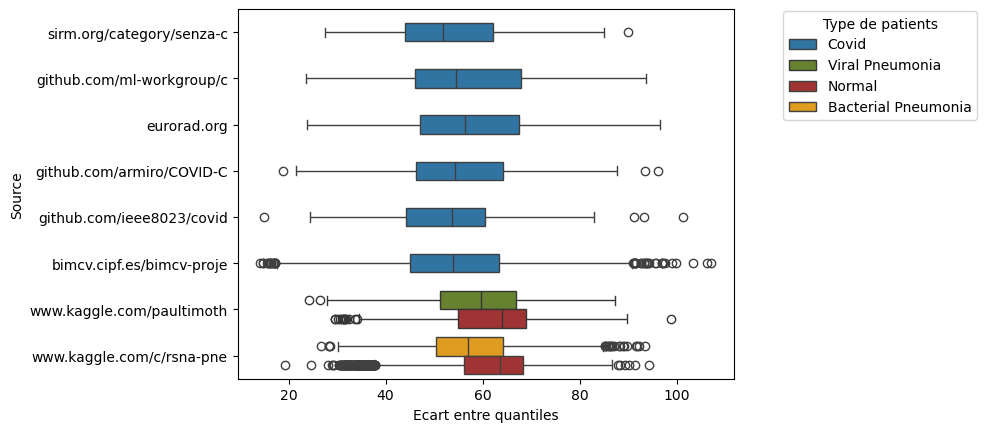

In [378]:
contrast_img_data['truncated_url'] = contrast_img_data.url.str.replace("https://", "").apply(lambda x: x[0:25])

sns.boxplot(data=contrast_img_data, x="data_type", y="contrast", hue='data_type')
plt.xticks(rotation=45)
plt.xlabel("Type de patients")
plt.ylabel("Ecart entre quantiles")
plt.show()

sns.boxplot(data=contrast_img_data[contrast_img_data.data_type=="Covid"], y="truncated_url", x="color_std", hue='data_type', width=0.4)
sns.boxplot(data=contrast_img_data[contrast_img_data.url=="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia"], y="truncated_url", x="color_std", hue='data_type', 
            palette={'Viral Pneumonia' : 'olivedrab', 'Normal' : 'firebrick'})
sns.boxplot(data=contrast_img_data[contrast_img_data.url=="https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data"], y="truncated_url", x="color_std", hue='data_type',
            palette={'Bacterial Pneumonia' : 'orange', 'Normal' : 'firebrick'})
plt.ylabel("Source")
plt.xlabel("Ecart entre quantiles")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(1.1,0.7), title="Type de patients",)


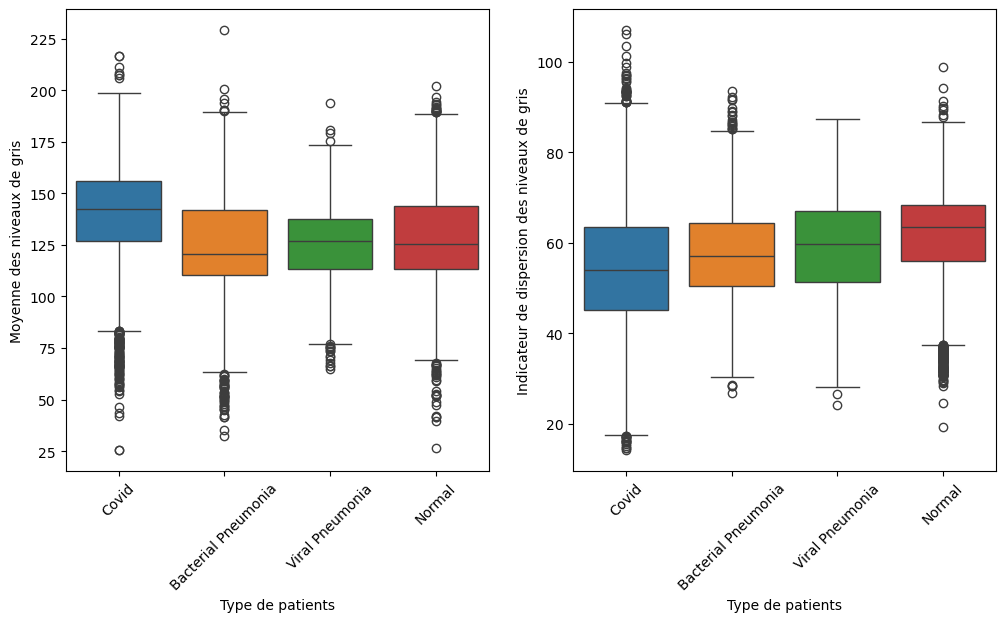

In [377]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.boxplot(data=contrast_img_data, x="data_type", y="color_mean", hue='data_type')
plt.xticks(rotation=45)
plt.xlabel("Type de patients")
plt.ylabel("Moyenne des niveaux de gris")

plt.subplot(1,2,2)
sns.boxplot(data=contrast_img_data, x="data_type", y="color_std", hue='data_type')
plt.xticks(rotation=45)
plt.xlabel("Type de patients")
plt.ylabel("Indicateur de dispersion des niveaux de gris")
plt.show()

# sns.boxplot(data=contrast_img_data, y="truncated_url", x="color_std", hue='data_type', width=1.5)
# plt.ylabel("Source")
# plt.ylim((-1,8))
# plt.xlabel("Dispersion des niveaux de gris")
# plt.legend(loc=(1.1,0.7), title="Type de patients")

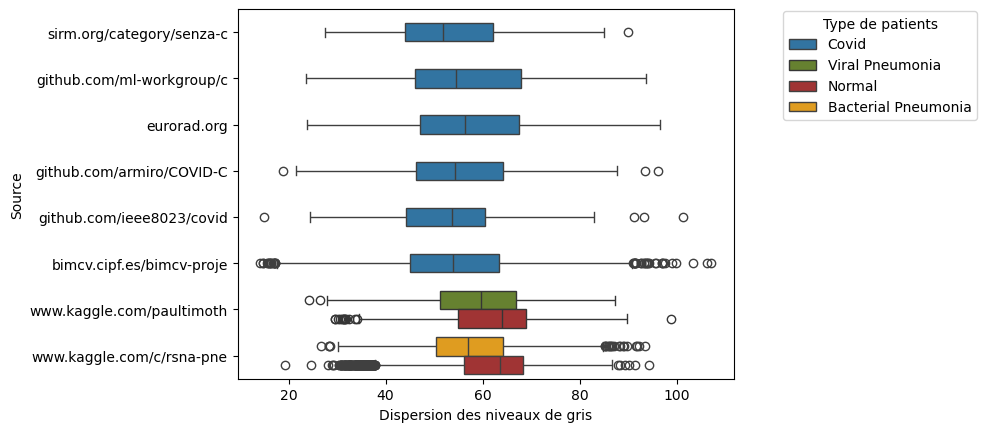

In [376]:
sns.boxplot(data=contrast_img_data[contrast_img_data.data_type=="Covid"], y="truncated_url", x="color_std", hue='data_type', width=0.4)
sns.boxplot(data=contrast_img_data[contrast_img_data.url=="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia"], y="truncated_url", x="color_std", hue='data_type', 
            palette={'Viral Pneumonia' : 'olivedrab', 'Normal' : 'firebrick'})
sns.boxplot(data=contrast_img_data[contrast_img_data.url=="https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data"], y="truncated_url", x="color_std", hue='data_type',
            palette={'Bacterial Pneumonia' : 'orange', 'Normal' : 'firebrick'})
plt.ylabel("Source")
plt.xlabel("Dispersion des niveaux de gris")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(1.1,0.7), title="Type de patients",)


## Recherche et identification d'outliers

In [459]:
seuils_outliers_mean = np.quantile(contrast_img_data.color_mean, q=(0.025))
low_color_level = contrast_img_data[(contrast_img_data.color_mean<seuils_outliers_mean)]

low_color_level.data_type.value_counts()

dir_images = dir_covid
filenames = low_color_level[low_color_level.data_type=='Covid'].file_name_x + '.png'
files_size = len(filenames)
covid_out = []
for i, filename in enumerate(filenames):
    covid_out.append(cv2.imread(os.path.join(dir_images, filename)))



In [460]:
print(low_color_level.shape)
print(filenames.shape)


(530, 7)
(142,)


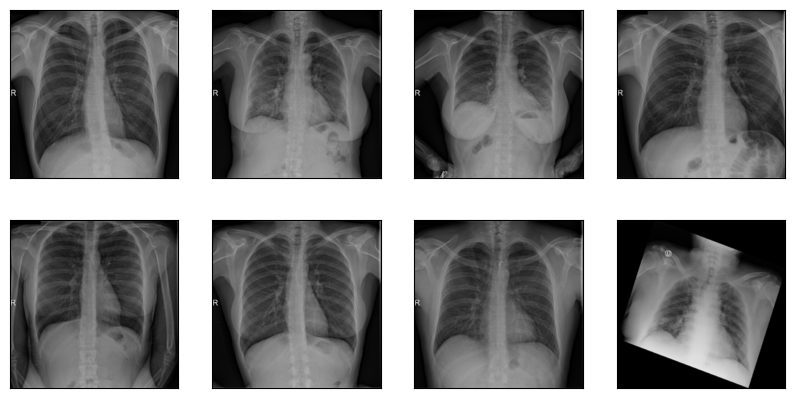

In [454]:
n_im = 8
ind_img = random.sample(list(np.arange(0,files_size)), n_im)
fig = plt.figure(figsize=(10, 10))

for i in range(round(n_im/2)) :
 ax = fig.add_subplot(1, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i]], cmap='gray')
 plt.xticks([])
 plt.yticks([])
 ax = fig.add_subplot(2, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i+round(n_im/2)]], cmap='gray')
 plt.xticks([])
 plt.yticks([])

In [455]:
# seuils_outliers_contrast = np.quantile(contrast_img_data.contrast, q=(0.025))
# low_contrast = contrast_img_data[(contrast_img_data.contrast<seuils_outliers_contrast)]

seuils_outliers_contrast = np.quantile(contrast_img_data.color_std, q=(0.025))
low_contrast = contrast_img_data[(contrast_img_data.color_std<seuils_outliers_contrast)]

low_contrast.data_type.value_counts()

dir_images = dir_covid
filenames = low_contrast[low_contrast.data_type=='Covid'].file_name_x + '.png'
files_size = len(filenames)
covid_out = []
for i, filename in enumerate(filenames):
    covid_out.append(cv2.imread(os.path.join(dir_images, filename)))


In [458]:
print(low_contrast.shape)
print(filenames.shape)


(530, 7)
(339,)


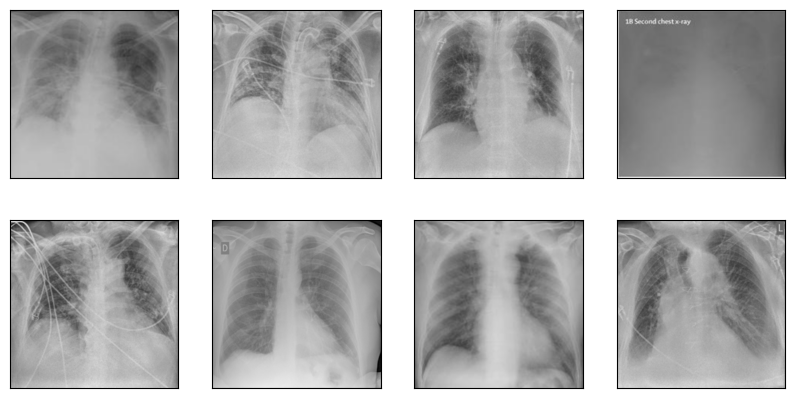

In [456]:
n_im = 8
ind_img = random.sample(list(np.arange(0,files_size)), n_im)
fig = plt.figure(figsize=(10, 10))

for i in range(round(n_im/2)) :
 ax = fig.add_subplot(1, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i]], cmap='gray')
 plt.xticks([])
 plt.yticks([])
 ax = fig.add_subplot(2, round(n_im/2), i+1)
 ax.imshow(covid_out[ind_img[i+round(n_im/2)]], cmap='gray')
 plt.xticks([])
 plt.yticks([])

